# TCC 2

## ANTES
Desenvolvimento de um processo de ETL (Web Scraping + CSV) e analise dos dados para definicao de principais métricas que levam à vitoria

- ETL dos dados
- Analises descritivas/estatísticas
- Plots de distribuição e frequencias

## AGORA

- mudanca temporal de tendencia dos dados

Atualização do conjunto de dados, 
criação e seleção de features

desnevolvimento de modelos de classificação para predição de resultados (Vitoria/Derrota)
Avaliar a capacidade de predição dos resultados das partidas de modelos de classificação 


outra idea: https://streamlit.io --> Aplicativo web em python para visualização interativa e dos dados.

- Engenharia de Features
    - OneHot [Agentes, ]
    - Novas Features [score de composicao]
    - Scaling/Standard [minmax, std_scale]
- Escolha de Modelos (Classificação)
    - Lineares/Logisticos (Regressao Logistica)
    - Arvores (Arvore de Decisao)
    - Ensembles (Random Forest)
    - Boosting (GradientBoosting, XGBoostingClass)
- Modelagem Extra
    - Cross Validation
    - Tunning de Hiperparametros (Grid Search)


In [1]:
## System
import re
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

## EDA
import numpy as np
import pandas as pd
import seaborn as sns
from pandas_profiling import ProfileReport
pd.set_option('display.max_columns', None)

---
## DATA IMPORT + CLEAN

In [2]:
##----------------------BASE FUNCTIONS FOR READING CSV AND FILTERING DATA

## IMPORT DATA FROM CSV FILE
def ImportData(team_file, type):
    folder = team_file + '/'
    maps_file = team_file + '_'+type+'_MAPS.csv'
    matches_file = team_file + '_'+type+'_MATCHES.csv'
    
    maps = pd.read_csv(CSV_PATH + folder + maps_file)
    matches = pd.read_csv(CSV_PATH + folder + matches_file)

    return maps, matches

## FILTER DATAFRAME BY GIVEN COLUMN ON GIVEN VALUE
def FilterCol(df, col, values):
    return df[df[col].isin(values)].reset_index(drop=True)

def BinaryTarget(variavel, quantil):
  bin = (variavel > variavel.quantile(q = quantil)).astype(int)
  return bin

##----------------------IMPORT + FILTERING DATA

## Aggregate base_geral by (Team, Match, Map)
def aggBase(base_geral):
    
    mean_agg_cols  = ['ACS', 'K',	'D',	'A',	'KD_DIFF',	'ADR',	'HS%', 'ECON']
    
    sum_agg_cols   = ['FK',	'FD', 'KPR',	'DPR',	'APR',	'FKPR'	,'FDPR',	
                        '2K'	,'3K',	'4K'	,'5K',	
                        '1v1','1v2',	'1v3'	,'1v4'	,'1v5' ,'PL',	'DE', 
                        'total_mult_kill', 'MKPR', 'total_clutch' ,'CPR'] + AGENTS
    
    first_agg_cols = ['Opp_Team_x', 'rounds_won'	,'rounds_lost', 'ct_rounds_won','ct_rounds_lost','t_rounds_won','t_rounds_lost' ,	
                        'total_rounds', 'win_rate', 'ct_wr' , 't_wr', 'RESULT']

    
    '''['Pistol_W','Pistol_P','Pistol_WR' ,'Eco_0_5_P','Eco_0_5_W','Eco_0_5_WR' ,
    'Semi_Eco_5_10_P', 'Semi_Eco_5_10_W','Semi_Eco_5_10_WR', 
    'Semi_Buy_10_20_P','Semi_Buy_10_20_W','Semi_Buy_10_20_WR',
    'Full_Buy_20_P'	,'Full_Buy_20_W','Full_Buy_20_WR']'''

    agg_first = base_geral.groupby(['Team_x','match_id','Map']).first()[first_agg_cols].reset_index()
    agg_sum = base_geral.groupby(['Team_x','match_id','Map']).sum()[sum_agg_cols].reset_index()
    agg_mean = base_geral.groupby(['Team_x','match_id','Map']).mean()[mean_agg_cols].reset_index().round(2)

    merge_agg = agg_mean.merge(agg_sum, how='inner', left_on=['Team_x','match_id','Map'],right_on=['Team_x','match_id','Map']).drop_duplicates()
    merge_agg = merge_agg.merge(agg_first, how='inner', left_on=['Team_x','match_id','Map'],right_on=['Team_x','match_id','Map']).drop_duplicates()

    #merge_agg = merge_agg.merge(economy_maps, how='inner', left_on=['match_id','Map','Team_x'],right_on=['match_id','Map','Team']).drop_duplicates()

    return merge_agg
    
## Get Map data for all teams
def AllTeamsMaps(files, type, team_col, filter_teams):
    concat = pd.concat([ImportData(team_file, type)[0] for team_file in files])
    #filter = FilterCol(concat, team_col, filter_teams)
    filter = concat

    filter[team_col][(filter[team_col] == 'NOOR') | (filter[team_col] == 'NOORG2.0')] = 'paiN'
    filter[team_col][filter[team_col] == 'Mix'] = 'IMP'
    filter[team_col][(filter[team_col] == 'Ingaming') | (filter[team_col] == 'NMDM')] = 'Inga'
    filter[team_col][filter[team_col] == 'FF'] = 'VORA'
    filter[team_col][(filter[team_col] == 'HAVA') | (filter[team_col] == 'HL')] = 'HAVAN'
    filter['Opp_Team'][(filter['Opp_Team'] == 'HAVA') | (filter['Opp_Team'] == 'HL')] = 'HAVAN'
    filter[team_col][filter[team_col] == 'FURI'] = 'FURIA'
    filter[team_col][(filter[team_col] == 'S5') | (filter[team_col] == 'Shar')] = 'Sharks'
    
    
    if type == 'overview': ExtraInfoMaps(filter)
    if type == 'performance':
        # total mult kill + mult kills per round
        filter['total_mult_kill'] = filter.loc[: ,['2K','3K','4K','5K']].sum(axis=1)	

        # total clutches + clutches per round
        filter['total_clutch'] = filter.loc[: ,['1v1','1v2','1v3','1v4','1v5']].sum(axis=1)
    return filter

## Get Match data for all teams
def AllTeamsMatches(files, type, team_col, filter_value):
    concat = pd.concat([ImportData(team_file, type)[1] for team_file in files])
    filter = FilterCol(concat, team_col, filter_value)
    
    filter[team_col][(filter[team_col] == 'NOOR') | (filter[team_col] == 'NOORG2.0')] = 'paiN'
    filter[team_col][filter[team_col] == 'Mix'] = 'IMP'
    filter[team_col][(filter[team_col] == 'Ingaming') | (filter[team_col] == 'NMDM')] = 'Inga'
    filter[team_col][filter[team_col] == 'FF'] = 'VORA'
    filter[team_col][filter[team_col] == 'HAVA'] = 'HAVAN'
    filter[team_col][filter[team_col] == 'FURI'] = 'FURIA'
    filter[team_col][(filter[team_col] == 'S5') | (filter[team_col] == 'Shar')] = 'Sharks'
    
    if type == 'overview': ExtraInfoMatches(filter)
    return filter

## ADD EXTRA INFO TO MATCHES DATAFRAME -- OVERVIEW
def ExtraInfoMatches(df):
    # KDA + FK/FD per map
    df['KPM'] = round(df['K'] / df['Num_maps'],2)
    df['DPM'] = round(df['D'] / df['Num_maps'],2)
    df['APM'] = round(df['A'] / df['Num_maps'],2)
    df['FKPM'] = round(df['FK'] / df['Num_maps'],2)
    df['FDPM'] = round(df['FD'] / df['Num_maps'],2)

## CLUTCH TOTAL, CLUTCH PER ROUND, MULT KILL TOTAL, MULT KILL PER ROUND

## ADD EXTRA INFO TO MAPS DATAFRAME -- OVERVIEW
def ExtraInfoMaps(df):

    # Total Rounds
    df['total_rounds'] = df['rounds_won'] + df['rounds_lost']

    # Round Win Rate
    df['win_rate'] = round(df['rounds_won'] / df['total_rounds'] * 100, 2)

    # KDA + FK/FD per Round
    df['KPR'] = round(df['K'] / df['total_rounds'],2)
    df['DPR'] = round(df['D'] / df['total_rounds'],2)
    df['APR'] = round(df['A'] / df['total_rounds'],2)
    df['FKPR'] = round(df['FK'] / df['total_rounds'],2)
    df['FKWR'] = round(100 * df['FK'] / (df['FK'] + df['FD']), 2)
    df['FDPR'] = round(df['FD'] / df['total_rounds'],2)

    # ATK/DEF Win rate -- ct_rounds_won	ct_rounds_lost	t_rounds_won	t_rounds_lost
    df['ct_wr'] = round(100 * df['ct_rounds_won'] / (df['ct_rounds_won'] + df['ct_rounds_lost']), 2)
    df['t_wr'] = round(100 * df['t_rounds_won'] / (df['t_rounds_won'] + df['t_rounds_lost']), 2)


    # Won/Lost Map 
    df['RESULT'] = ['W' if x == True
                    else 'L'
                    for x in df['rounds_won'] > df['rounds_lost']]

## One Hot Encoding Categorical Cols
def GetDummies(df, cat_cols):

    for col in cat_cols:
        one_hot = pd.get_dummies(df[col])
        #df.drop(col, axis=1, inplace=True)
        df = pd.concat([df, one_hot], axis=1)
    return df


In [3]:
ALL_FILES = ['gamelanders', 'pain', 'vorax', 'havan', 'imperial', 'ingaming', 'vikings', 'black_dragons', 'furia', 'rise', 'slick', 'sharks']
ALL_TEAMS = ['GL', 'IMP','Mix', 'HAVAN', 'HAVA', 'Inga', 'Ingaming', 'NMDM', 'VKS', 'FF', 'VORA', 'BD', 'paiN','NOOR', 'NOORG2.0', 
                'S5', 'Sharks', 'Shar', 'FURI', 'FURIA', 'Rise', 'SLK']

MAPS = ['ASCENT', 'BIND', 'HAVEN', 'ICEBOX', 'SPLIT']

DUELIST = ['jett', 'raze', 'phoenix','reyna', 'yoru']
CONTROLLER = ['omen', 'brimstone', 'viper', 'astra'] 
SENTINEL = ['cypher', 'sage', 'killjoy'] 
INITIATOR = ['breach', 'sova', 'skye']
AGENTS = DUELIST + CONTROLLER + SENTINEL + INITIATOR

CSV_PATH = '../data/csv/'
EXCEL_PATH = '../data/excel/'

overview_maps = AllTeamsMaps(ALL_FILES, 'overview', 'Team', ALL_TEAMS)
performance_maps = AllTeamsMaps(ALL_FILES, 'performance', 'Team', ALL_TEAMS)
#economy_maps = AllTeamsMaps(ALL_FILES, 'economy', 'Team', ALL_TEAMS)

overview_maps.drop('Patch',axis=1, inplace=True)
performance_maps.drop('Patch',axis=1, inplace=True)

base_geral = overview_maps.merge(performance_maps, how='inner', left_on=['match_id','Map','Player'],right_on=['match_id','Map','Player']).drop_duplicates()
#base_geral = merge_over_perf.merge(economy_maps, how='inner', left_on=['match_id','Map','Team_x'],right_on=['match_id','Map','Team']).drop_duplicates()

base_geral = base_geral.replace(np.nan, 0)
base_geral = GetDummies(base_geral, ['Agents'])

base_geral['MKPR'] = round(base_geral['total_mult_kill'] / base_geral['total_rounds'], 2)
base_geral['CPR'] = round(base_geral['total_clutch'] / base_geral['total_rounds'], 2)

base_agg = aggBase(base_geral)
base_agg = base_agg.replace(np.nan, 0)
base_agg[AGENTS] = base_agg[AGENTS].replace(2, 1)
base_agg = base_agg[base_agg.FKPR < 1]
base_agg.RESULT = base_agg.RESULT.replace({'W':1, 'L': 0})
base_agg = base_agg.sort_values(['match_id', 'Map']).reset_index(drop=True)
base_agg = base_agg.drop(780,axis=0).reset_index(drop=True)
print(base_agg.shape) 

#jett raze phoenix	reyna yoru	
# omen brimstone viper astra	
# cypher sage killjoy 
# breach	sova	skye

agro =    [3,3,2,2,2, 1,0,0,0, 0,0,0, 0,0,0]
tempo =   [0,0,1,1,0, 2,2,1,1, 0,1,0, 3,2,3]
control = [0,0,0,0,1 ,0,1,2,2, 3,2,3, 0,1,0]

base_agg['agro_score'] = base_agg[AGENTS].dot(agro)
base_agg['tempo_score'] = base_agg[AGENTS].dot(tempo)
base_agg['control_score'] = base_agg[AGENTS].dot(control)

base_len = base_agg.shape[0]-1
for idx in range(base_len):
    if idx % 2 == 0:
        base_agg.at[idx, 'opp_agro_score'] = base_agg.at[idx + 1, 'agro_score']
        base_agg.at[idx, 'opp_tempo_score'] = base_agg.at[idx + 1, 'tempo_score']
        base_agg.at[idx, 'opp_control_score'] = base_agg.at[idx + 1, 'control_score']
    else: 
        base_agg.at[idx, 'opp_agro_score'] = base_agg.at[idx - 1, 'agro_score']
        base_agg.at[idx, 'opp_tempo_score'] = base_agg.at[idx - 1, 'tempo_score']
        base_agg.at[idx, 'opp_control_score'] = base_agg.at[idx - 1, 'control_score']
        
base_agg.at[base_len, 'opp_agro_score'] = base_agg.at[base_len - 1, 'agro_score']
base_agg.at[base_len, 'opp_tempo_score'] = base_agg.at[base_len - 1, 'tempo_score']
base_agg.at[base_len, 'opp_control_score'] = base_agg.at[base_len - 1, 'control_score']

(1062, 60)


In [31]:
base_geral

,Player,Agents,ACS,K,D,A,KD_DIFF,ADR,HS%,FK,FD,FK_FD_DIFF,match_id,Team_x,Opp_Team_x,rounds_won,rounds_lost,ct_rounds_won,ct_rounds_lost,t_rounds_won,t_rounds_lost,Map,total_rounds,win_rate,KPR,DPR,APR,FKPR,FKWR,FDPR,ct_wr,t_wr,RESULT,2K,3K,4K,5K,1v1,1v2,1v3,1v4,1v5,ECON,PL,DE,Team_y,Opp_Team_y,total_mult_kill,total_clutch,0,astra,breach,brimstone,cypher,jett,killjoy,omen,phoenix,raze,reyna,sage,skye,sova,viper,yoru,MKPR,CPR
0,Jonn,jett,398,22,9,5,13,224.6,18,3,1,2,6797,GL,IMP,13,3,10,2,3,1,SPLIT,16,81.25,1.38,0.56,0.31,0.19,75.00,0.06,83.33,75.00,W,6,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,115,0,0,GL,IMP,8.0,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.50,0.06
1,mwzera,raze,268,14,12,5,2,181.0,17,2,1,1,6797,GL,IMP,13,3,10,2,3,1,SPLIT,16,81.25,0.88,0.75,0.31,0.12,66.67,0.06,83.33,75.00,W,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74,0,0,GL,IMP,4.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.25,0.00
2,JhoW,omen,185,13,8,7,5,103.9,19,1,1,0,6797,GL,IMP,13,3,10,2,3,1,SPLIT,16,81.25,0.81,0.50,0.44,0.06,50.00,0.06,83.33,75.00,W,3,0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,38,3,0,GL,IMP,3.0,2.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.19,0.12
3,fznnn,cypher,155,8,9,9,-1,83.6,14,1,5,-4,6797,GL,IMP,13,3,10,2,3,1,SPLIT,16,81.25,0.50,0.56,0.56,0.06,16.67,0.31,83.33,75.00,W,3,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,31,0,0,GL,IMP,3.0,1.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.19,0.06
4,Nyang,breach,131,8,10,3,-2,66.6,15,0,1,-1,6797,GL,IMP,13,3,10,2,3,1,SPLIT,16,81.25,0.50,0.62,0.19,0.00,0.00,0.06,83.33,75.00,W,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,30,0,1,GL,IMP,2.0,1.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.12,0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11487,Mazino,viper,289,19,11,11,8,174.5,16,2,3,-1,19082,KRÃ,SHK,13,6,7,5,6,1,BIND,19,68.42,1.00,0.58,0.58,0.11,40.00,0.16,58.33,85.71,W,5,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70,1,0,KRÃ,SHK,5.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.26,0.00
11488,delz1k,brimstone,253,19,8,5,11,146.5,27,1,0,1,19082,KRÃ,SHK,13,6,7,5,6,1,BIND,19,68.42,1.00,0.42,0.26,0.05,100.00,0.00,58.33,85.71,W,5,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61,0,0,KRÃ,SHK,5.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.26,0.00
11489,Klaus,skye,198,13,8,4,5,122.1,22,2,0,2,19082,KRÃ,SHK,13,6,7,5,6,1,BIND,19,68.42,0.68,0.42,0.21,0.11,100.00,0.00,58.33,85.71,W,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68,1,0,KRÃ,SHK,3.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.16,0.00
11490,NagZ,sage,157,11,10,4,1,88.9,20,2,2,0,19082,KRÃ,SHK,13,6,7,5,6,1,BIND,19,68.42,0.58,0.53,0.21,0.11,50.00,0.11,58.33,85.71,W,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35,1,1,KRÃ,SHK,3.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.16,0.00


---
## ML

In [10]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

## ML models
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
#from xgboost import XGBClassifier

from sklearn import metrics

In [13]:
stats_cols = ['ACS', #'K', 'D', 'A',
                #'Map',
                'KD_DIFF', 'ADR', 'ECON',
                'FK', 'FD', 'KPR', 'DPR', 'FKPR', 'FDPR',
                '2K', '3K', #'4K', '5K', 
                '1v1','1v2',
                #'1v3','1v4','1v5',
                #'PL','DE',
                'agro_score', 'tempo_score', 'control_score',
                'opp_agro_score', 'opp_tempo_score', 'opp_control_score', 
                'MKPR', 'CPR', 
                'ct_wr', 't_wr']
target_col = 'RESULT'

In [15]:
base_agg[stats_cols + AGENTS]

,ACS,KD_DIFF,ADR,ECON,FK,FD,KPR,DPR,FKPR,FDPR,2K,3K,1v1,1v2,agro_score,tempo_score,control_score,opp_agro_score,opp_tempo_score,opp_control_score,MKPR,CPR,ct_wr,t_wr,jett,raze,phoenix,reyna,yoru,omen,brimstone,viper,astra,cypher,sage,killjoy,breach,sova,skye
0,147.2,-4.2,100.60,41.8,7,13,2.50,3.55,0.35,0.65,6,3,0.0,0.0,8,6,1,7.0,4.0,4.0,0.45,0.00,33.33,37.50,0,1,1,1,0,1,0,0,0,0,0,0,0,1,0
1,201.6,4.2,124.10,50.0,13,7,3.55,2.50,0.65,0.35,8,6,0.0,0.0,7,4,4,8.0,6.0,1.0,0.75,0.00,62.50,66.67,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0
2,219.4,3.0,138.44,58.4,12,11,3.87,3.23,0.53,0.48,14,4,2.0,1.0,6,5,4,4.0,7.0,4.0,0.91,0.13,72.73,41.67,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0
3,182.4,-3.4,122.52,45.0,11,12,3.17,3.92,0.49,0.52,11,3,2.0,0.0,4,7,4,6.0,5.0,4.0,0.62,0.08,58.33,27.27,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0
4,187.2,-1.8,118.56,48.2,12,14,3.31,3.66,0.46,0.54,15,4,4.0,0.0,6,5,4,7.0,4.0,4.0,0.73,0.16,50.00,50.00,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057,219.6,2.2,134.24,54.2,11,10,3.86,3.33,0.52,0.49,13,5,0.0,1.0,5,5,5,3.0,6.0,6.0,0.95,0.05,88.89,41.67,0,1,1,0,0,0,0,1,1,0,0,0,0,1,0
1058,239.0,6.8,144.14,66.8,15,3,4.39,2.51,0.85,0.18,13,2,1.0,1.0,5,4,6,5.0,4.0,6.0,1.00,0.12,75.00,66.67,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0
1059,155.4,-6.8,94.38,40.2,3,15,2.51,4.39,0.17,0.84,9,0,2.0,0.0,5,4,6,5.0,4.0,6.0,0.62,0.11,33.33,25.00,1,0,1,0,0,0,0,0,1,1,0,0,0,1,0
1060,232.2,5.4,144.42,64.6,11,6,4.23,2.65,0.65,0.36,8,4,1.0,0.0,2,5,8,3.0,4.0,8.0,0.95,0.12,60.00,83.33,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0


In [ ]:
base_agg[AGENTS].sum().sort_values(ascending=False)

In [9]:
mm_scaler = MinMaxScaler()
std_scaler = StandardScaler()

base_minmax = base_agg.loc[ : , stats_cols]
base_std = base_agg.loc[: , stats_cols]

base_minmax[stats_cols] = mm_scaler.fit_transform(X=base_agg[stats_cols])
base_std[stats_cols] = std_scaler.fit_transform(X=base_agg[stats_cols])

<AxesSubplot:ylabel='Density'>

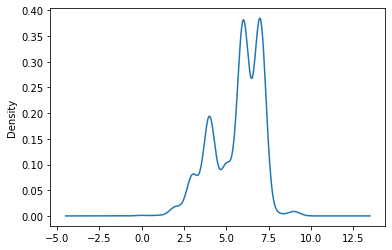

In [11]:
base_agg.agro_score.plot(kind='kde')

In [140]:
base_minmax

,ACS,KD_DIFF,ADR,ECON,FK,FD,KPR,DPR,FKPR,FDPR,2K,3K,1v1,1v2,agro_score,tempo_score,control_score,opp_aggro_score,opp_tempo_score,opp_control_score,MKPR,CPR,ct_wr,t_wr
0,0.447321,0.283861,0.417618,0.217391,0.272727,0.571429,0.288608,0.479212,0.325843,0.648352,0.147059,0.250000,0.000000,0.00,0.888889,0.571429,0.000,0.777778,0.285714,0.375,0.251656,0.000,0.3333,0.3750
1,0.690179,0.719772,0.542924,0.306522,0.545455,0.285714,0.554430,0.249453,0.662921,0.318681,0.205882,0.500000,0.000000,0.00,0.777778,0.285714,0.375,0.888889,0.571429,0.000,0.450331,0.000,0.6250,0.6667
2,0.769643,0.657499,0.619388,0.397826,0.500000,0.476190,0.635443,0.409190,0.528090,0.461538,0.382353,0.333333,0.333333,0.25,0.666667,0.428571,0.375,0.444444,0.714286,0.375,0.556291,0.325,0.7273,0.4167
3,0.604464,0.325376,0.534499,0.252174,0.454545,0.523810,0.458228,0.560175,0.483146,0.505495,0.294118,0.250000,0.333333,0.00,0.444444,0.714286,0.375,0.666667,0.428571,0.375,0.364238,0.200,0.5833,0.2727
4,0.625893,0.408407,0.513384,0.286957,0.500000,0.619048,0.493671,0.503282,0.449438,0.527473,0.411765,0.333333,0.666667,0.00,0.666667,0.428571,0.375,0.777778,0.285714,0.375,0.437086,0.400,0.5000,0.5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057,0.770536,0.615983,0.596993,0.352174,0.454545,0.428571,0.632911,0.431072,0.516854,0.472527,0.352941,0.416667,0.000000,0.25,0.555556,0.428571,0.500,0.333333,0.571429,0.625,0.582781,0.125,0.8889,0.4167
1058,0.857143,0.854696,0.649781,0.489130,0.636364,0.095238,0.767089,0.251641,0.887640,0.131868,0.352941,0.166667,0.166667,0.25,0.555556,0.285714,0.625,0.555556,0.285714,0.625,0.615894,0.300,0.7500,0.6667
1059,0.483929,0.148936,0.384451,0.200000,0.090909,0.666667,0.291139,0.663020,0.123596,0.857143,0.235294,0.000000,0.333333,0.00,0.555556,0.285714,0.625,0.555556,0.285714,0.625,0.364238,0.275,0.3333,0.2500
1060,0.826786,0.782045,0.651274,0.465217,0.454545,0.238095,0.726582,0.282276,0.662921,0.329670,0.205882,0.333333,0.166667,0.00,0.222222,0.428571,0.875,0.333333,0.285714,0.875,0.582781,0.300,0.6000,0.8333


In [141]:
## Split data in train and test

features = stats_cols #+ AGENTS

X_train, X_test, y_train, y_test = train_test_split(
        base_minmax, base_agg[target_col], 
        test_size=0.33, random_state=69, shuffle=True)

In [70]:
## Logistic Regression -- decisao via arvore

log_reg = LogisticRegressionCV(cv=5,max_iter=200,n_jobs=-1,random_state=69).fit(X_train, y_train)

logreg_score = log_reg.score(X_test, y_test)
logreg_pred = log_reg.predict(X_test)

print(metrics.classification_report(y_test, logreg_pred))
print(metrics.confusion_matrix(y_test, logreg_pred))

In [145]:
print(metrics.classification_report(y_test, logreg_pred))
print(metrics.confusion_matrix(y_test, logreg_pred))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92       178
           1       0.90      0.94      0.92       173

    accuracy                           0.92       351
   macro avg       0.92      0.92      0.92       351
weighted avg       0.92      0.92      0.92       351

[[160  18]
 [ 11 162]]


In [72]:
## DECISION TREE -- decisao via arvore

dtree_class = DecisionTreeClassifier(random_state=69).fit(X_train, y_train)

dtree_score = dtree_class.score(X_test, y_test)
dtree_pred = dtree_class.predict(X_test)

In [78]:
dtree_score
metrics.confusion_matrix(y_test, dtree_pred)

array([[157,  16],
       [ 16, 162]])

In [74]:
## RANDOM FOREST -- ensemble de arvores


random_forest = RandomForestClassifier(random_state=69).fit(X_train, y_train)

forest_score = random_forest.score(X_test, y_test)
forest_pred = random_forest.predict(X_test)

In [75]:
forest_score

0.9458689458689459

In [76]:
## GRADIENT BOOSTING -- ensemble de gradiente

features = stats_cols

grad_boost = GradientBoostingClassifier(random_state=69).fit(X_train, y_train)

gboost_score = grad_boost.score(X_test, y_test)
gboost_pred = grad_boost.predict(X_test)

In [77]:
gboost_score

0.9430199430199431

--- 
## Brainstorm Section
- dividir dados em derrotas e vitorias e analisar estatisticas de cada split

In [39]:
wins = base_agg[stats_cols + ['RESULT']][base_agg.RESULT==1]
losses = base_agg[stats_cols + ['RESULT']][base_agg.RESULT==0]
wins.columns

Index(['ACS', 'KD_DIFF', 'ADR', 'ECON', 'FK', 'FD', 'KPR', 'DPR', 'FKPR',
       'FDPR', '2K', '3K', '1v1', '1v2', 'agro_score', 'tempo_score',
       'control_score', 'MKPR', 'CPR', 'ct_wr', 't_wr', 'RESULT'],
      dtype='object')

<AxesSubplot:ylabel='Density'>

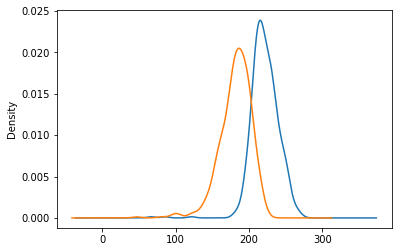

In [33]:
col = 'gboost_score'
wins[col].plot(kind='kde')
losses[col].plot(kind='kde')

<AxesSubplot:ylabel='Density'>

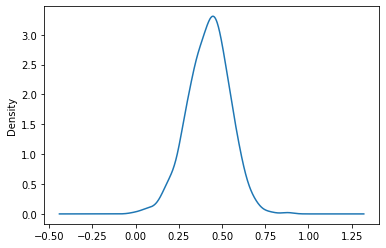

In [23]:
losses.FKPR.plot(kind='kde')